# Mudanças climáticas: uma análise pythônica

In [1]:
%%HTML
<img src="earth_on_fire.jpg">

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

global_temp_country = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
cd = pd.read_csv("archive.csv")
df = pd.read_csv("GlobalLandTemperaturesByState.csv")
si = pd.read_csv("seaice.csv")

# Mapeamento da temperatura média nos países

In [3]:
#Let's remove the duplicated countries (in the analysis, we don't consider the presence of 
#colonies at this the countries) and countries for which no information about the temperature

global_temp_country_clear = global_temp_country[~global_temp_country['Country'].isin(
    ['Denmark', 'Antarctica', 'France', 'Europe', 'Netherlands',
     'United Kingdom', 'Africa', 'South America'])]

global_temp_country_clear = global_temp_country_clear.replace(
   ['Denmark (Europe)', 'France (Europe)', 'Netherlands (Europe)', 'United Kingdom (Europe)'],
   ['Denmark', 'France', 'Netherlands', 'United Kingdom'])

#Let's average temperature for each country

countries = np.unique(global_temp_country_clear['Country'])
mean_temp = []
for country in countries:
    mean_temp.append(global_temp_country_clear[global_temp_country_clear['Country'] == 
                                               country]['AverageTemperature'].mean())


    
data = [ dict(
        type = 'choropleth',
        locations = countries,
        z = mean_temp,
        locationmode = 'country names',
        text = countries,
        marker = dict(
            line = dict(color = 'rgb(0,0,0)', width = 1)),
            colorbar = dict(autotick = True, tickprefix = '', 
            title = '# Average\nTemperature,\n°C')
            )
       ]

layout = dict(
    title = 'Average land temperature in countries',
    geo = dict(
        showframe = False,
        showocean = True,
        oceancolor = 'rgb(0,255,255)',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 60,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)'
            ),
        lataxis = dict(
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)'
                )
            ),
        )

fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='worldmap')

# Temperatura média no Brasil ao longo dos anos

In [15]:
#clean up year
def to_year(date):
    """
    returns year from date time
    """
    for i in [date]:
        first = i.split('-')[0]
        return int(first)
 
df['year'] = df['dt'].apply(to_year)

#select only data from the united states
dfs = df[df['Country'] == 'Brazil']


#calculate average temp per year
dfa = pd.DataFrame()
years = dfs['year'].unique()
for i in years:
    df_avg = dfs[dfs['year'] == i]['AverageTemperature'].mean()
    df_new = (dfs[dfs['year'] == i]).head(1)
    df_new['AverageTemperature'] = df_avg
    dfa = dfa.append(df_new)
 
dfa.plot.scatter(x='year', y='AverageTemperature', c = 'AverageTemperature', cmap ='coolwarm', title='Temperatura média no Brasil')

SyntaxError: invalid syntax (<ipython-input-15-53598f34d970>, line 27)

# Manipulação de dados

In [5]:
#calculate average extend per year
sia = pd.DataFrame()
years = si['Year'].unique()

for i in years:
    si_avg = si[si['Year'] == i]['Extent'].mean() 
    si_new = (si[si['Year'] == i]).head(1)
    si_new['Extent'] = si_avg
    sia = sia.append(si_new)

In [6]:
#average CO2 ppm per year
dfc = pd.DataFrame()
years = cd['Year'].unique()
for i in years:
    df_avg = cd[cd['Year'] == i]['Carbon Dioxide (ppm)'].mean()
    df_new = (cd[cd['Year'] == i]).head(1)
    df_new['Carbon Dioxide (ppm)'] = df_avg
    dfc = dfc.append(df_new)
 
#change Year column to year
dfc.rename(index=str, columns={"Year": "year"}, inplace=True)
sia.rename(index=str, columns={"Year": "year"}, inplace=True)

#merge CO2 data with temp and sea ice data
merge_co2 = pd.merge(dfa, dfc, on=['year'])
dfcss = pd.merge(merge_co2, sia, on=['year'])

#drop unwanted columns
dfcss.drop(['Seasonally Adjusted CO2 (ppm)', 
           'Carbon Dioxide Fit (ppm)', 
           'Seasonally Adjusted CO2 Fit (ppm)',
          'Decimal Date', 'Month_x', 'Month_y', 'Day', 'Missing', ], inplace=True, axis=1)


# Concentração de CO2 ao longo dos anos

In [7]:
%%HTML
<center><img src="Carbon-Pollution.jpg"></center>

Text(0.5,1,'Carbon dioxide vs years')

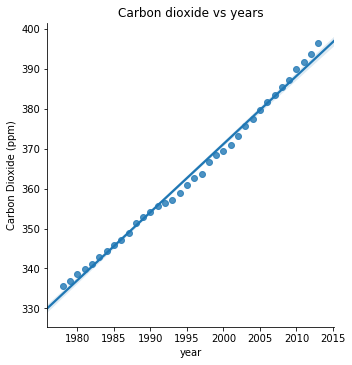

In [8]:
# Linear regression CO2 vs year
sns.lmplot(x='year', y='Carbon Dioxide (ppm)', data=dfcss)
ax = plt.gca()
ax.set_title("Carbon dioxide vs years")

Text(0.5,1,'Carbon Dioxide vs Average Temperature')

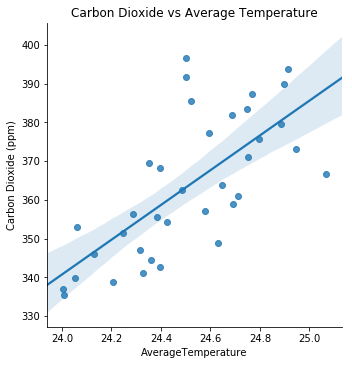

In [9]:
# Linear regression Co2 vs average temperature
sns.lmplot(x='AverageTemperature', y='Carbon Dioxide (ppm)', data =dfcss)
ax = plt.gca()
ax.set_title("Carbon Dioxide vs Average Temperature")

# Extensão das calotas polares

In [10]:
%%HTML
<center><img src="polar_bear.jpg"></center>

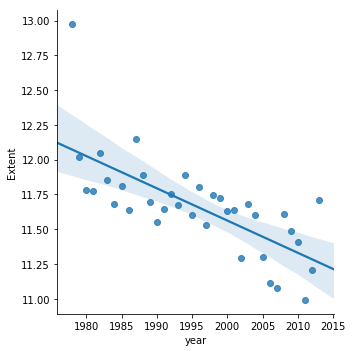

In [11]:
# Linear regression extent vs year
sns.lmplot(x='year', y='Extent', data=dfcss)

# Correlações

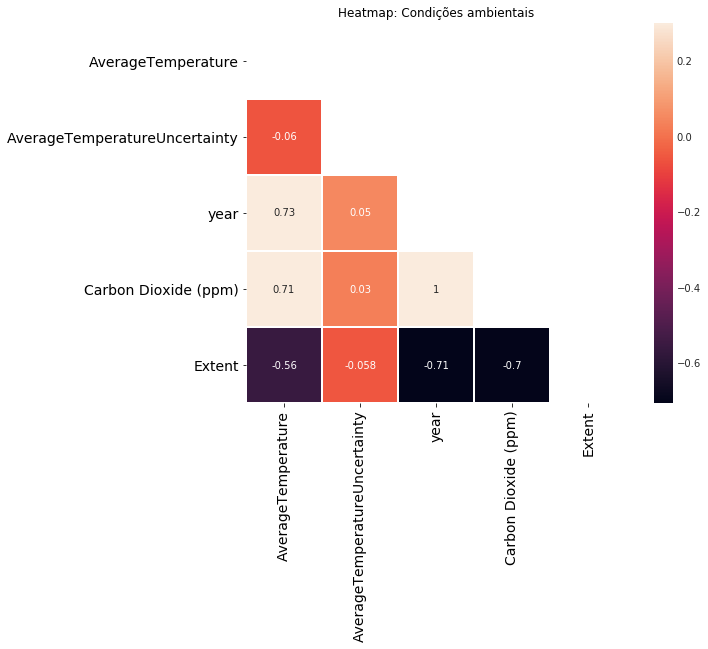

In [12]:
def heatmap(df):
    fig, axes = plt.subplots(figsize=(10, 7))
    corr = df.corr()            # Calculate correlation of param

    mask = np.zeros_like(corr)   # Create a array of zeros with the same shape as the df provided
    # print(mask)

    mask[np.triu_indices_from(mask)] = True    # set the index of the upper triangle of the array to True (1)
    # print(mask)

    with sns.axes_style("white"):
        sns.heatmap(corr, linewidths=1, 
                    annot=True, 
                    mask=mask, 
                    vmax=.3, 
                    square=True)  # mask: data will not be
                                                                                           # shown in cells where mask
                                                                                           #  is True

    axes.set_title('Heatmap: Condições ambientais')
    plt.yticks(rotation=0, fontsize=14)
    plt.xticks(rotation=90, fontsize=14)
    plt.show()
    
# Function call
heatmap(dfcss)